In [1]:
from tensorflow.test import is_built_with_cuda
from tensorflow.config import list_physical_devices
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# display setup
plt.style.use("seaborn-v0_8")  # for plots

In [2]:
print(is_built_with_cuda())
print(f"GPUs Available: {list_physical_devices('GPU')}")

True
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

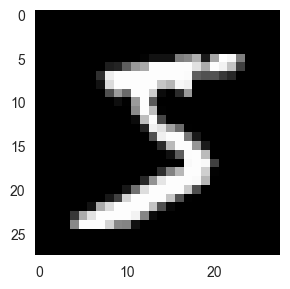

In [4]:
plt.figure(figsize=(3, 3))
plt.imshow(X_train_full[0], cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.show()

In [5]:
y_train_full[0]

5

In [6]:
X_train_full.shape

(60000, 28, 28)

In [7]:
X_train_full.dtype

dtype('uint8')

In [8]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# y_valid = keras.utils.to_categorical(y_valid, num_classes=10)
# y_train = keras.utils.to_categorical(y_train, num_classes=10)

In [9]:
y_valid[0]

5

# Summary of Network Details (pg. 11-12 in the article)
## ResNet18s:
* Kernel size: 7x7, stride: 2
* Activation: ReLU
* Filters (per layer): 64, 64, 128, 256
* Weights: Xavier/Glorot initialization
* Epochs: 90
* Batch size (default): 256
* Learning rate (default): 1, decay by a factor of 10 in epochs 30, 60, 80
* Optimizer: SGD with 0.9 momentum
* Regularizers: Batch normalization, data augmentation, random cropping and flipping, 0.0001 weight decay.

## Inception-v3s:
* Kernel size:
* Activation:
* Filters (per layer):
* Weights: Truncated normal 0.1,
* Epochs: 90
* Batch size (default): 256
* Learning rate (default): 1, exponential decay by 4% every 8 epochs
* Optimizer: RMSProp
* Regularizers: Weight decay 0.00004, augmentation with random cropping and flipping,
    batch norm 0.9997 decay with epsilon 0.001 (avoid division by zero)

## AlexNets:
5 layers: 2 convolutional, 2 dense, 1 output layer
* Kernel size: 5x5, stride 1
* Max pooling: 3x3, stride 2 (local response normalization after each pooling- see article for exact params.
* Activation: ReLU
* Filters (per layer): 1x Size Model: convolutions 96 and 256 filters, dense 384 and 192 units.
* Weights: Xavier/Glorot initialization
* Batch size (default): 128
* Learning rate (default): 0.01, exponential decay by 5% every epoch
* Optimizer: SGD with 0.9 momentum
* Regularizers: None

## ResNet56s:
Convolutional layers 16, 16, 32, 64, 128 filters
* Kernel size: 3x3, stride 1
* Activation: ReLU
* Filters (per layer):
* Weights: Xavier/Glorot initialization
* Epochs: 182
* Batch size (default): 128
* Learning rate (default): 1, decay factor 10 at epochs 91 and 136
* Optimizer: SGD with 0.9 momentum
* Regularizers: Batch normalization, data augmentation with random cropping and flipping
    (except for randomly labeled data variants), 0.0002 weight decay.

## MLP:
* Size: Single hidden layer with 128 units + bias and binary output
* Activation: ReLU
* Weights: Normal distribution with std 0.01.
* Epochs (default): 50
* Batch size (default): 128

# First Model: CNN

https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook

* Size: 2 convolutional layers (32, 64 maps), 128 units in the dense layer
* Activation: ReLU
* Dropout: 40%
* Optimizer: Adam

In [10]:
learning_rate_cb = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32,
                        kernel_size=5,
                        padding='same',
                        activation='relu',
                        input_shape=(28, 28, 1),
                        kernel_initializer="glorot_uniform"),  # glorot is the default
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(filters=64,
                        kernel_size=5,
                        padding='same',
                        activation='relu',
                        kernel_initializer="glorot_uniform"),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation='softmax')  # output layer
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("Models/model1.h5",
                                                save_best_only=True)

In [12]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, learning_rate_cb])

Epoch 1/30
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2231 - accuracy: 0.9307 - val_loss: 0.0549 - val_accuracy: 0.9824 - lr: 0.0010

In [13]:
# model = keras.models.load_model("Models/model1.h5")

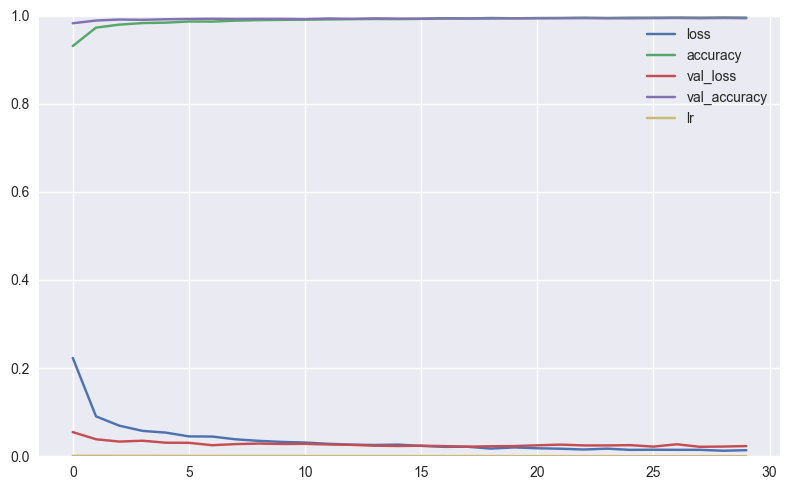

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [15]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 5ms/step - loss: 0.0232 - accuracy: 0.9938

[0.023184632882475853, 0.9937999844551086]

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

In [17]:
np.argmax(model.predict(X_valid), axis=1)

157/157 [==============================] - 0s 2ms/step


array([5, 0, 4, ..., 2, 1, 2], dtype=int64)

# Questions for Meeting 2
1. Which metrics should be used to measure redundancy and robustness?
2. Which parameters should we experiment with more? Add layers? Optimizers?
3. How to measure the contribution of the neurons?
4. Should we test robustness when the amount of training examples is larger than the parameters trained?
5. Should we update the learning rate during training and how?
6. How many epochs? Is an early stopping callback relevant?
7. When should we evaluate the test set?